# Rotterdam stylized case

In [1]:
from classes import *
import copy
from collections import OrderedDict
import csv
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path
#import ipywidgets as widgets
import pickle

import tqdm


from models import Rotty
from mayors import *

### Load the model with parameters

In [2]:
#global pars (for the development of Trust) Will be removed 
k = 0.2 
T_eq = 70
Rotty

Rotty 
-----------
allFloodProtection: 
No 3.5; Dike 4.5;  
-----------
allResidentialArea: 
Area_A Protected by:['No']
Area_B Protected by:['Dike']

Parameters : 
{'alarming_conditions': OrderedDict([(1, ['Major flood', 40]), (0, ['Small flood', 20]), (-0.2, ['Near miss', 10]), (-0.4, ['Major wake-up', 7]), (-1, ['Minor wake-up', 5]), (-10, ['Nothing happens', 0])]), 'Gumbel': OrderedDict([('mu', 2.33), ('beta', 0.234)]), 'I_experience_interp': {'xp': [0, 0.5], 'fp': [0, 1]}, 'I_social': 1}

### Load SLR and storm surge scenarios

In [3]:
select_SLR = ['1']
select_SH = ['0','1','2','3']

reset_scenarios() #Does not work well... why?

# Load and filter SLR_Scenario
allSLR_Scenario = SLR_Scenario_from_pickles(Path('SLR_projections','Transients'))
selected_SLR_Scenario = [x for x in allSLR_Scenario if x.name[-1] in select_SLR]

#Load all SurgeHeight (Realisations of extreme value distribution)
for path in Path('SurgeHeight','biased_from_five_hundred').glob('*.csv'):
    if path.stem.split('_')[-1] in select_SH:
        obj = SurgeHeight(path.stem) #Init object with name derived from filename
        obj.from_csv(path) #Fill the object with data from the csv file

# Create SurgeLevels by summing combinations of SLR_Scenario and SurgeHeights
for SLR_Scenario in selected_SLR_Scenario:
    for SH in allSurgeHeight:
        combine_SurgeLevel(SLR_Scenario,SH)
        
print(allSurgeLevel)

allSLR_Scenario, allSurgeHeight, and allSurgeLevel emptied
[Scenario_01__five_hundred_0, Scenario_01__five_hundred_1, Scenario_01__five_hundred_2, Scenario_01__five_hundred_3]


### Load adaptation strategies (Mayors)

In [4]:
allMayors = [Reactive(),Economicus(),Sentiment(),Lawkeeper()]

### Select implementation times of measures

In [5]:
Implementation_times = [ #small measure, large measure
    (4,6),
    (5,7),
    (6,9), 
    (7,10), #default
    (8,11),
    (9,13),
    (10,14),
    (11,16),
    (12,17),
    (13,19),
    (14,20)]

In [12]:
it_sel = 1 #select the it_pairs from the list

### Model run algorithm

In [13]:
from run_model import run_model01

### Run the behaviour of one Mayor

In [14]:
#run one mayor:
experiments = []
for SurgeLevel in allSurgeLevel:
    experiment = run_model01(Rotty,SurgeLevel,Economicus(),Implementation_times[it_sel],do_print=True)
    experiments.append(experiment)
print('experiments finished')

Finished experiment Rotty_Scenario_01__five_hundred_0_H. Economicus 2020/10/23, 12:12:35
Finished experiment Rotty_Scenario_01__five_hundred_1_H. Economicus 2020/10/23, 12:12:36
Finished experiment Rotty_Scenario_01__five_hundred_2_H. Economicus 2020/10/23, 12:12:36
Finished experiment Rotty_Scenario_01__five_hundred_3_H. Economicus 2020/10/23, 12:12:36
experiments finished


### Plot the results

Target folder Visualisations\2020_10_23 already exists


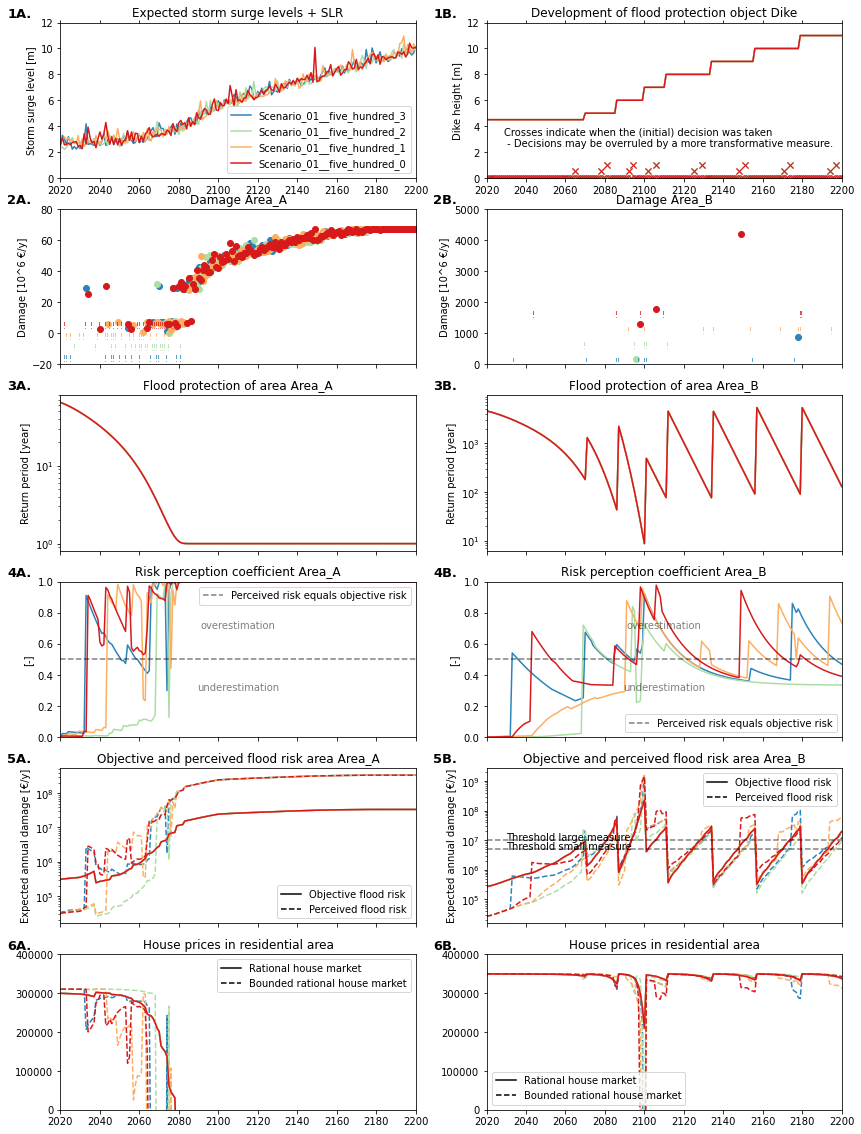

In [15]:
p1 = ['#e66101','#fdb863','#b2abd2','#5e3c99'] #palette
p2 = ['#d7191c','#fdae61','#abd9e9','#2c7bb6']
p3 = ['#d7191c','#fdae61','#abdda4','#2b83ba']
p = p3
p.reverse()

nrows=6
ncols=2

fig, axes = plt.subplots(nrows=nrows,ncols=ncols,sharey=False,sharex=True,figsize=(14,20))

labels = []

xlim = (2020,2200)

for j,experiment in enumerate(reversed(experiments)):
    
    Model = experiment.Model
    SurgeLevel = experiment.SurgeLevel
    Mayor = experiment.Mayor
    
    time = SurgeLevel.years
    
    axes[0,0].plot(time,SurgeLevel.surgelevel,color=p[j])

    labels.append(SurgeLevel.name)
    axes[0,0].set_title('Expected storm surge levels + SLR')
    #axes[0,0].set_xlabel('Time [year]')
    axes[0,0].set_ylabel('Storm surge level [m]')
    axes[0,0].set_ylim(0,12)
    axes[0,1].set_ylim(0,12)
    axes[0,1].set_ylabel('Dike height [m]')
    
    axes[0,0].set_xlim(xlim[0],xlim[1])
    
    axes[0,1].plot(time,Model.allFloodProtection[1].measure_history,'x',color=p[j]) #PLOT THE HISTORY OF THE MEASURES

    for i, Area in enumerate(Model.allResidentialArea):
        axes[0,i].tick_params(axis='x',reset=True) # to repeat the x-labels along the axes
       
           
        #plot damage
        axes[1,i].set_title('Damage {}'.format(Area.name))
        axes[1,i].plot(time,[x*10**(-6) for x in Model.allResidentialArea[i].flood_damage],'o',color=p[j])
        axes[1,i].set_ylabel('Damage [10^6 \u20ac/y]')
        #axes[1,i].tick_params(axis='x',reset=True) # to repeat the x-labels along the axes
    
        axes[2,i].set_title('Flood protection of area {}'.format(Model.allResidentialArea[i].name))
        axes[2,i].plot(time,Model.allResidentialArea[i].protection_level_rp,'-',color=p[j])
        axes[2,i].set_yscale("log")
        axes[2,i].set_ylabel('Return period [year]')
        #axes[2,i].tick_params(axis='x',reset=True) # to repeat the x-labels along the axes
    
        axes[3,i].set_title('Risk perception coefficient {}'.format(Model.allResidentialArea[i].name))
        axes[3,i].plot(time,Model.allResidentialArea[i].risk_perception,'-',color=p[j])
        axes[3,i].set_ylabel('[-]')
        axes[3,i].set_ylim(0,1)

        #axes[3,i].tick_params(axis='x',reset=True) # to repeat the x-labels along the axes
        
        axes[4,i].set_title('Objective and perceived flood risk area {}'.format(Model.allResidentialArea[i].name))
        unit_corr = [x * 10**6 for x in Model.allResidentialArea[i].risk]
        axes[4,i].plot(time,unit_corr,'-',color=p[j])
        axes[4,i].set_yscale("log")
        axes[4,i].set_ylabel('Expected annual damage [\u20ac/y]')
        #axes[4,i].tick_params(axis='x',reset=True) # to repeat the x-labels along the axes
        #Manually add legend patches
        custom_lines = [Line2D([0], [0], color='black',label='Objective flood risk',linestyle='-'),
                        Line2D([0], [0], color='black',label='Perceived flood risk',linestyle='--')]
        axes[4,i].legend(handles=custom_lines)
        
        unit_corr2 = [x * 10**6 for x in Model.allResidentialArea[i].risk_perceived]
        axes[4,i].plot(time,unit_corr2,'--',color=p[j])
        
        axes[5,i].set_title('House prices in residential area')
        axes[5,i].plot(time,Area.house_price_t_objective,color=p[j])
        custom_lines = [Line2D([0], [0], color='black',label='Rational house market',linestyle='-'),
                        Line2D([0], [0], color='black',label='Bounded rational house market',linestyle='--')]
        axes[5,i].legend(handles=custom_lines)
        axes[5,i].set_ylim(0,4e5)
        
        
        
        axes[5,i].plot(time,Area.house_price_t_subjective,'--',color=p[j])
        
        #axes[6,i].set_title('Development of trust in {} [DEPRECIATED]'.format(Area.name))
        #axes[6,i].plot(time,Model.allResidentialArea[i].trust_t,color=p[j])
        #axes[6,i].set_ylim(0,100)
    
    axes[0,1].plot(time,Model.allFloodProtection[1].protection_level,color=p[j])
    axes[0,1].set_title('Development of flood protection object Dike')
    
       
    #PLOT THE WAKE-UP CALL SIGNALS
    axes[1,0].set_ylim(-20,80)
    HP = Model.allResidentialArea[0]
    for i,year in enumerate(time[0:xlim[1]-xlim[0]]):
        text = HP.event_history[i]
        if text == "!":
            axes[1,0].text(year,-18 + 7 * j,text,color=p[j],fontsize=8)
            
    #PLOT THE WAKE-UP CALL SIGNALS
    axes[1,1].set_ylim(0,5000)
    CC = Model.allResidentialArea[1]
    for i,year in enumerate(time[0:xlim[1]-xlim[0]]):
        text = CC.event_history[i]
        if text == "!":
            axes[1,1].text(year,0 + 500 * j,text,color=p[j],fontsize=8)

axes[0,0].legend(labels)

axes[0,1].text(0.05,0.2,"Crosses indicate when the (initial) decision was taken \n - Decisions may be overruled by a more transformative measure.",transform=axes[0,1].transAxes)


#PRINT THE THRESHOLD PROTECTION LEVELS FOR THE LAWKEEPER MAYOR
if Mayor.get_name() == 'Lawkeeper':
    axes[2,1].plot(time,[Mayor.threshold_small]*len(time),color='black',linestyle='--',alpha=0.5)
    axes[2,1].plot(time,[Mayor.threshold_large]*len(time),color='black',linestyle='--',alpha=0.5)
    axes[2,1].text(2030,Mayor.threshold_small - 4000,'Threshold small measure',color='black',alpha=1)
    axes[2,1].text(2030,Mayor.threshold_large - 800,'Threshold large measure',color='black',alpha=1)
    
#PRINT THE THRESHOLD PROTECTION LEVELS FOR THE MAYOR ECONOMICUS
if Mayor.get_name() == 'H. Economicus':
    axes[4,1].plot(time,[Mayor.threshold_small*1e6]*len(time),color='black',linestyle='--',alpha=0.5)
    axes[4,1].plot(time,[Mayor.threshold_large*1e6]*len(time),color='black',linestyle='--',alpha=0.5)
    axes[4,1].text(2030,Mayor.threshold_small*1e6 - 4000,'Threshold small measure',color='black',alpha=1)
    axes[4,1].text(2030,Mayor.threshold_large*1e6 - 800,'Threshold large measure',color='black',alpha=1)
    
for j in [0,1]:
    alpha = 0.5
    color = 'black'
    axes[3,j].plot(time,[0.5]*len(time),color=color,linestyle='--',alpha = alpha)    
    #Manually add legend patches
    custom_line = [Line2D([0], [0], color=color, alpha=alpha,label='Perceived risk equals objective risk',linestyle='--')]
    axes[3,j].legend(handles=custom_line)
    axes[3,j].text(0.5,0.3,'underestimation',color=color,alpha=alpha,transform=axes[3,j].transAxes,ha='center')
    axes[3,j].text(0.5,0.7,'overestimation',color=color,alpha=alpha,transform=axes[3,j].transAxes,ha='center')


for nr in range(0,nrows):
    for l,letter in enumerate(('A','B')):
        axes[nr,l].text(-0.15, 1.1, "{}{}.".format(nr+1,letter), transform=axes[nr,l].transAxes,
                       fontsize=13, fontweight='bold', va='top')
    

#################################################################    
#################### SAVE THE EXPERIMENT ########################
#################################################################

its = Implementation_times[it_sel]
filename = experiment.Mayor.get_name() + "_trans_" + experiment.SurgeLevel.name.split("__")[1] + "_it_" + str(its)

#CREATE SUBFOLDER IN VISUALISATION WITH CURRENT DATE
today = datetime.date(datetime.now())
date = "{}_{}_{}".format(today.year,today.month,today.day)
target = Path('Visualisations',date)
if not Path.exists(target): target.mkdir()
else: print("Target folder {} already exists".format(target))

fig.savefig(Path(target, (filename + ".png")),bbox_inches='tight',dpi=150)


In [13]:
Mayor.get_name()

'H. Economicus'

# Explore tipping points

Text(0.5, 0.98, 'this is the title')

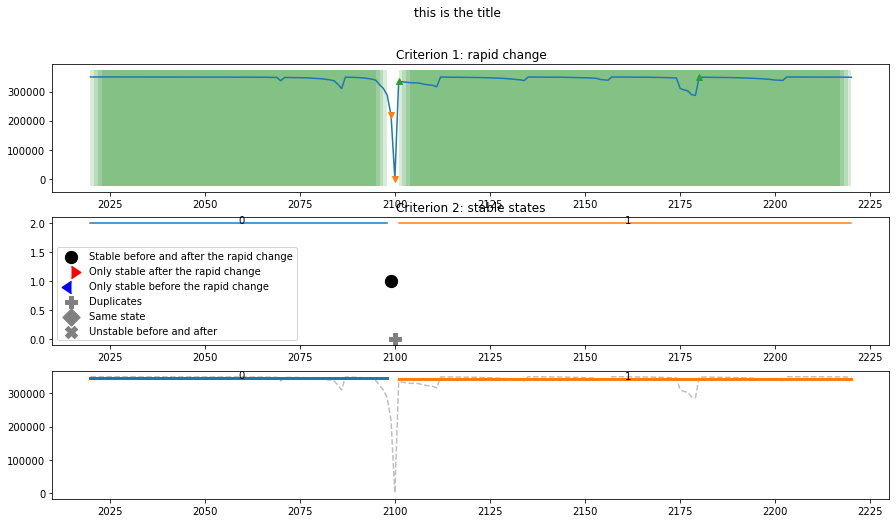

In [19]:

#for experiment in experiments:
experiment.create_Metrics()
M = experiment.allMetrics[3]
M.create_statistics()
M.find_SETP_candidates(c1=0.15,c2=0.2e10,c3=10, window=4,margin=2)
M.select_SETPs(sign=-1)
fig, ax = M.plot_SETPs(window=4)

fig.suptitle('this is the title')
    
    

In [26]:
experiment.__dict__.keys()

dict_keys(['Model', 'SurgeLevel', 'Mayor', 'time', 'name', 'allMetrics'])

In [25]:
title = experiment.name + "_it_" + str(its)
title

'Rotty_Scenario_01__five_hundred_3_H. Economicus_it_(5, 7)'

(<Figure size 1080x576 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000023F6BC334C0>,
       dtype=object))

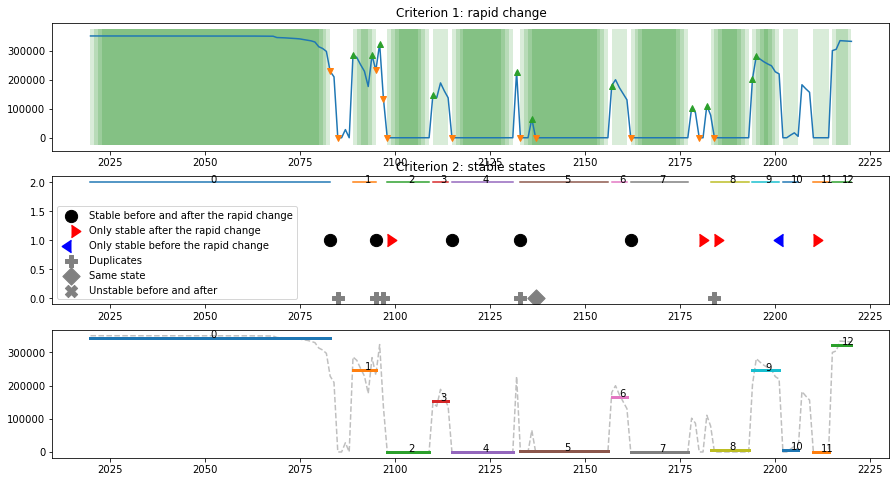

In [20]:
e = experiments[0]
M = e.allMetrics[3]
M.plot_SETPs(window=4)